In [29]:
import xarray as xr
import pandas as pd
import numpy as np
import tqdm as tqdm

import datetime
import json

from fooof import FOOOF, FOOOFGroup
from neurodsp.spectral import compute_spectrum

from poirot.spectrum import specparam_attributes, process_spectrum


In [34]:
# Constants

SUBS = ['S001', 'S002', 'S003', 'S004', 'S005', 'S006', 'S007',
        'S008', 'S009', 'S010', 'S011', 'S012', 'S013', 'S014', 'S015']

# PSD Computation
FS = 600
NPERSEG = 2*FS
METHOD = 'medfilt'

# SPECPARAMS
FREQ_RANGE = [2, 45]
spec_params = {
    'peak_width_limits': [2, 10.0],
    'max_n_peaks': 6,
    'min_peak_height': 0.1,
    'peak_threshold': 2.0,
    'aperiodic_mode': 'fixed'
}

def create_specparam_object(spec_params: dict, mode :str = 'single'):
    if mode == 'group':
        return FOOOFGroup(**spec_params)
    elif mode == 'single':
        return FOOOF(**spec_params)
    else:
        raise ValueError('model must be either group or single')

fg = create_specparam_object(spec_params, mode='group')

# PATHS
DATA_FOLDER = "/Volumes/ExtremePro/Analyses/ASP0"
DATA_FOLDER_LOCAL = "../../data"
OUTPUT_FOLDER= f"{DATA_FOLDER_LOCAL}/OUTPUT"

df_list = []
stacked_cols = ['labels', 'sub', 'session']
fg = create_fooof_group()

for subject in SUBS:
    ds = xr.open_dataarray(
        f"{DATA_FOLDER }/interim/timeseries/{subject}_MEG_ASSR_times.nc")
    ds.close()
    df = (
        process_spectrum(ds, fs = FS, nperseg = NPERSEG, method=METHOD)
        .stack(trial_iter_number=('trial', 'iter_number'))
        .mean("trial_iter_number")
        .pipe(
            specparam_attributes,
            stacked_cols=stacked_cols,
            fg=fg,
            freq_range=FREQ_RANGE,
        )
    )
    df_list.append(df)
df_concat = pd.concat(df_list)


Running FOOOFGroup: 100%|██████████| 136/136 [00:01<00:00, 68.63it/s]


,CF,PW,BW,offset,exponent,error,r_squared
count,7255.000000,7255.000000,7255.000000,7255.000000,7255.000000,7255.000000,7255.000000
mean,15.158039,0.415176,3.619221,-23.481828,0.764578,0.030929,0.985782
std,6.450651,0.328415,2.222641,0.664253,0.237771,0.011204,0.012135
min,2.001334,0.003922,2.000000,-25.188956,0.144932,0.013264,0.775701
25%,10.293249,0.165155,2.000000,-23.974500,0.601451,0.022902,0.983822
50%,13.719675,0.311349,2.567240,-23.459075,0.749480,0.027556,0.988956
75%,20.163994,0.566926,4.431292,-23.034416,0.910593,0.035671,0.991983
max,43.387842,2.004376,10.000000,-21.124868,1.716228,0.098888,0.996996


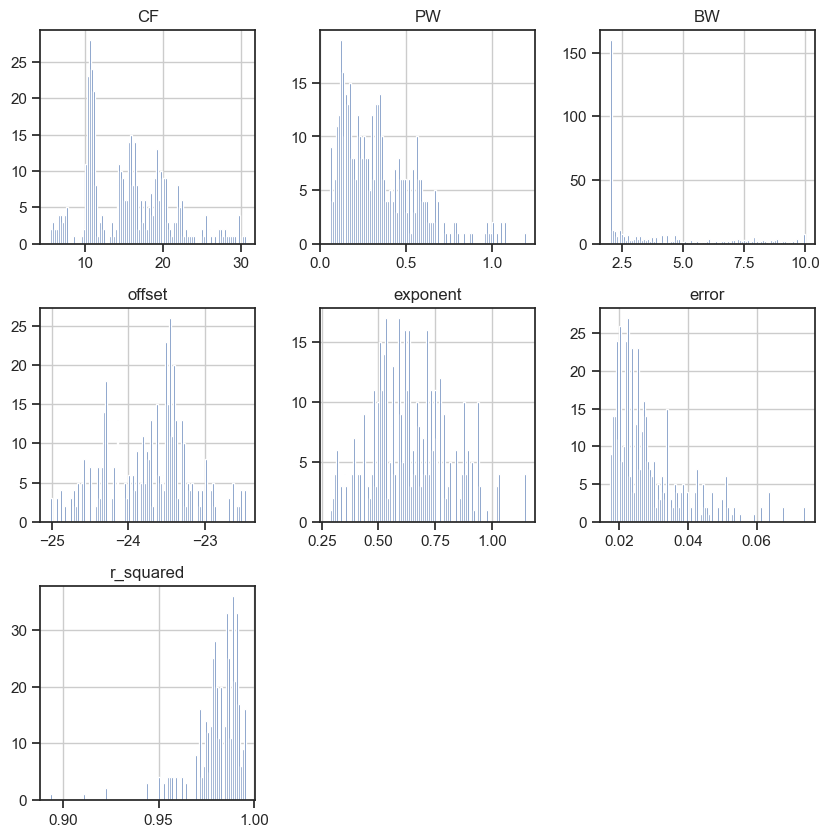

In [35]:
display(df_concat.describe())
df.hist(figsize=(10,10), bins=100);

In [38]:

sessions = (
    pd.read_csv(f"{DATA_FOLDER_LOCAL}/SessionAssignment.csv",  delimiter=";")
    .melt(id_vars='Subject', var_name='Session', value_name='type')
    .assign(type=lambda x: x['type'].str.replace(' ', ''))
    .assign(type=lambda x: x['type'].replace(u'\xa0', u'', regex=True))
    .rename(columns={'Subject': 'subject', 'Session': 'session'})

)
display(sessions.head())

final = (
    df_concat
   .rename(columns={'sub': 'subject'})
    .merge(sessions, on=['subject', 'session'], how='left')
)

display(final.head())


# Get the current date and time
now = datetime.datetime.now()

# Format the date as a string to include in the filename
date_string = now.strftime("%Y-%m-%d")

# Save the DataFrame to a CSV file with the current date in the filename
csv_name = f"{OUTPUT_FOLDER}/specparam_values_{date_string}.csv"
dict_name = f"{OUTPUT_FOLDER}/specparam_params_{date_string}.json"
final.to_csv(csv_name, index=False)


with open(dict_name , 'w') as f:
    json.dump(spec_params , f)


,subject,session,type
0,S001,Session1,real
1,S002,Session1,sham
2,S003,Session1,sham
3,S004,Session1,sham
4,S005,Session1,real


,labels,subject,session,regions,CF,PW,BW,offset,exponent,error,r_squared,type
0,bankssts L,S001,Session1,LT,10.535393,0.522624,4.697746,-23.823427,0.830980,0.027176,0.990424,real
1,bankssts L,S001,Session1,LT,16.354481,0.135341,2.000000,-23.823427,0.830980,0.027176,0.990424,real
2,bankssts L,S001,Session1,LT,19.559400,0.134214,5.838559,-23.823427,0.830980,0.027176,0.990424,real
3,bankssts L,S001,Session1,LT,24.414276,0.066288,10.000000,-23.823427,0.830980,0.027176,0.990424,real
4,bankssts L,S001,Session2,LT,9.289009,0.556602,3.362615,-23.628333,0.916173,0.025416,0.992459,sham
